# Comparing protein length between GenomeNexus to length derived from CDS
This notebook compares:
  1. The protein length derived from Genome Nexus, originally from Ensembl
  2. The protein length derived from `Home_sampiens.GRCh37.87.gff3` which is also from Ensembl, but contains the locations of exons, untranslated regions (UTRs). With this information, we can calculate the coding sequence (CDS). For complete transcripts, dividing the length of CDS by 3 and subtracting 1 amino acid for stop codon, will result in the length of the protein sequence. 

## Calculation
First we calculate the protein length based on the sequence in the GFF3 file.

In [90]:
import numpy as np
import requests
import matplotlib.pyplot as mpl
mpl.style.use('ggplot')

input_gff_file = '/Users/sander/Desktop/Homo_sapiens.GRCh37.87.gff3'
transcript_dict = {}
transcript_id = ''
mRNA_entry = False

def calculate_protein_length(transcript_dict, transcript_id):
    # The stopcodon is not translated, therefore subtract of the protein length.
    transcript_dict[transcript_id]['calculated_protein_length'] = (((transcript_dict[transcript_id]['total_length_exons'] - transcript_dict[transcript_id]['total_length_utr']) / 3 ) - 1)
    return transcript_dict

with open(input_gff_file, 'r') as input_gff:
    
    for line in input_gff:
        line_list = line.strip().split("\t")

        if line[0] != '#':
            # All protein coding transcripts start with a row containing 'mRNA'
            if line_list[2] == 'mRNA':

                # For the previous transcript, calculate the length
                if transcript_id != '':
                    transcript_dict = calculate_protein_length(transcript_dict, transcript_id)

                # Retrieve data
                attribute_dict = dict(item.split("=") for item in line_list[8].split(";"))
                transcript_id = attribute_dict['ID'].split(':')[1]
                transcript_dict[transcript_id] = {}
                transcript_dict[transcript_id]['total_length_exons'] = 0
                transcript_dict[transcript_id]['total_length_utr'] = 0

                # Many non-coding transcripts are also contained in the file, therefore only check exons and UTRs when it's mRNA
                mRNA_entry = True

            # Ranges are inclusive, therefore add 1 basepair to obtain the correct number of bases per region
            elif line_list[2] == 'exon' and mRNA_entry:
                transcript_dict[transcript_id]['total_length_exons'] = (int(line_list[4]) - int(line_list[3]) + 1) + transcript_dict[transcript_id]['total_length_exons']
            elif line_list[2] in ['five_prime_UTR', 'three_prime_UTR'] and mRNA_entry:
                transcript_dict[transcript_id]['total_length_utr'] = (int(line_list[4]) - int(line_list[3]) + 1) + transcript_dict[transcript_id]['total_length_utr']
            elif line_list[2] == 'CDS':
                pass
            
            # There can be a row between transcripts of the same gene
            else:
                mRNA_entry = False
                
        # All genes end with a row containing '###'
        elif line[0:3] == '###':
            mRNA_entry = False
                                
    # For the last transcript, calculate the length
    transcript_dict = calculate_protein_length(transcript_dict, transcript_id)            

Secondly, we retrieve the protein lengths from Genome Nexus

In [109]:
"""Retrieve transcript and exons information from Genome Nexus."""
request_url = "http://genomenexus.org/ensembl/transcript"
request_headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}
request_data = '{ "transcriptIds" : ["%s"] }' % ('", "'.join(transcript_dict.keys()))
request = requests.post(url=request_url, headers=request_headers, data=request_data)

# Parse transcripts and exons from JSON
result_json = request.json()


Lastly, we compare the lengths and plot the result.

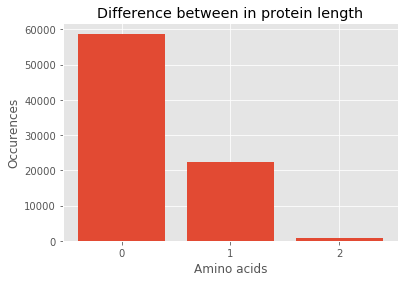

In [120]:
protein_length_dict = {}
for transcript in result_json:
    transcriptId = transcript['transcriptId']

    if 'proteinLength' not in transcript:
        protein_length_dict[transcriptId] = None
    else:
        protein_length_dict[transcriptId] = transcript['proteinLength']

difference_list = []
for i in transcript_dict:

    difference = protein_length_dict[i] - transcript_dict[i]['calculated_protein_length']
    difference_list.append(difference)

keys, counts = np.unique(difference_list, return_counts=True)
plt.bar(keys, counts, tick_label = ['0', '1', '2'],)
plt.title('Difference between in protein length')
plt.ylabel('Occurences')
plt.xlabel('Amino acids')
plt.show()

There is a difference between the calculated protein lengths and the Genome Nexus protein lenghts, for about 1 third of the transcripts. After manual inspection of these transcript, it appears that the CDS is incomplete on ENSEMBL. Therefore, a stop or start codon is often missing. This has been described on http://lists.ensembl.org/pipermail/dev/2014-April/010022.html. 

### Example
An example of this is ENST00000134644 on http://feb2014.archive.ensembl.org/Homo_sapiens/Transcript/Exons?db=core;g=ENSG00000134644;r=1:31532126-31534763;t=ENST00000531867. This length of the protein is 96 basepairs, while the (coding sequence / 3 ) - 1 results in 95 basepairs. If you manually inspect the basepairs, you will notice a appears a stop codon is missing. The upper table describes this incompleteness by "CDS incomplete" on the "3'". 

## Conclusion

### Incomplete transcripts
The CDS can be incomplete on both the 5' and 3' side of the transcript, which leads to differences in the protein lengths. Although these differences appear to be small, they are only caused by missing start or stop codons. This means that the difference can be larger. For our visualization this does not matter, because UniProt displays the same length as the (incomplete) length on Ensembl (and Genome Nexus). This means the location of PFAM domains are also drawn regardless of the (incomplete) length.

### Next step
To map the PFAM domains on exons of a transcript, multiply the PFAM domain locations by 3, and add the 5' UTR. I think that potentially drawing 1 amino acid less on either side is not a problem.

### Example
For example, a transcript is 
  - 500 bases long
  - has 100 bp 5' UTR
  - has 50 bp 3' UTR
The PFAM domain is located on protein locations 40-60. 

When drawing the locations of PFAM domains on reference transcript, that consists of all exons, <b>including the UTRs</b>:
- PFAM start on transcript = 40\*3 + 100 = location 220 of the reference transcript.
- PFAM end on transcript = 60\*3 + 100 = location 280 of the reference transcript.

# PFAM
Additionaly, we checked whether the PFAM positions and protein lenghts in Ensembl are the same. This looks like it, since PFAM uses UniProt ("Pfam pre-calculates the domain compositions and architectures for all the proteomes present in our snapshot of UniProt proteomes. "

Protein lengths are from Ensembl Lookup (http://grch37.rest.ensembl.org/documentation/info/lookup and https://github.com/genome-nexus/genome-nexus-importer/blob/88f0d68d1ffc877af2f54921950aa576336c9062/scripts/download_transcript_info_from_ensembl.py#L7).

PFAM positions from Ensembl are retrieved through BioMart. (https://github.com/genome-nexus/genome-nexus-importer/tree/88f0d68d1ffc877af2f54921950aa576336c9062#pfam-endpoint)